In [42]:
%cd "/content/drive/MyDrive/AI_Workshops/Final Assesment/Finalized"

/content/drive/MyDrive/AI_Workshops/Final Assesment/Finalized


In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

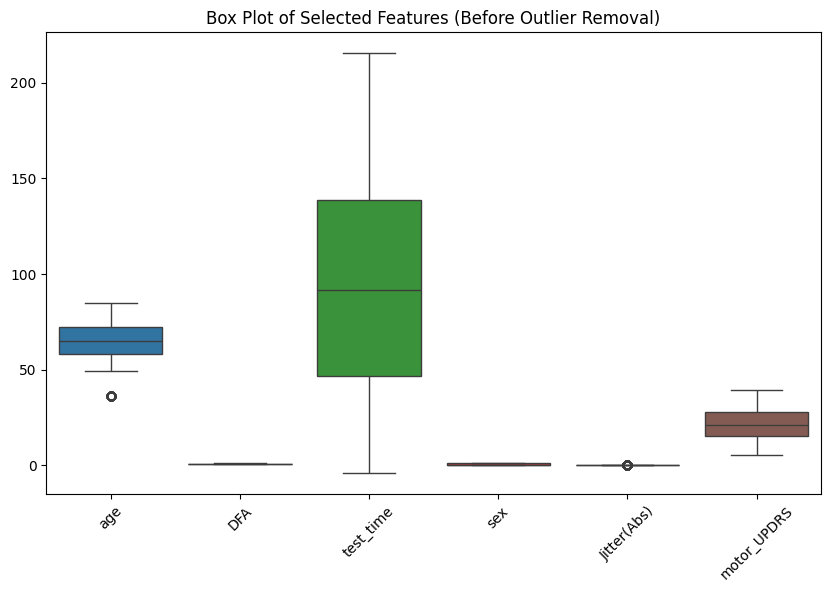

In [44]:
dataset = pd.read_csv('parkinsons.data')
dataset = dataset.drop(columns=['subject#','total_UPDRS'])

# Top 5 best featuers
dataset = dataset[['age', 'DFA', 'test_time', 'sex', 'Jitter(Abs)','motor_UPDRS']]
columns_to_check = ['age', 'DFA', 'test_time', 'sex', 'Jitter(Abs)','motor_UPDRS']

plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset)
plt.xticks(rotation=45)
plt.title("Box Plot of Selected Features (Before Outlier Removal)")
plt.show()

In [45]:

print("Shape before removing outliers:", dataset.shape)
for column in columns_to_check:
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    dataset = dataset[(dataset[column] >= lower_bound) & (dataset[column] <= upper_bound)]

print("Shape after removing outliers:", dataset.shape)


max_value = dataset['motor_UPDRS'].max()
min_value = dataset['motor_UPDRS'].min()



Shape before removing outliers: (5875, 6)
Shape after removing outliers: (5414, 6)


In [46]:
class Node():
    def __init__(self, threshold=None, left=None, right=None, var_red=None, value=None, feature_index=None):
        self.threshold = threshold
        self.left = left
        self.right = right
        self.var_red = var_red
        self.feature_index = feature_index
        self.value = value

class DecisionTreeRegressorCustom():
    def __init__(self, max_depth=2, min_samples_split=2, min_samples_leaf=1):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf

    def build_tree(self, X, Y, current_depth=0):
      '''
        Recursively Builds The Tree Based On Information Gain.

        This function splits the data and travers it building branches until
        either one of the stopping conditions has been met.

        Args:
          X (numpy array): Feature
          Y (numpy array): Target
          curr_depth (int): used to keep track of the tree depth.
        Returns:
          Node: A Node Object representing the current split. Either a subtree,
          or a leaf node.
      '''
      num_samples, num_features = X.shape
      best_split = {}

      if num_samples >= self.min_samples_split and current_depth <= self.max_depth:
          best_split = self.get_best_split(X, Y, num_samples, num_features)

          if best_split and best_split["var_red"] > 0:
              left_X, left_Y = best_split["dataset_left"]
              right_X, right_Y = best_split["dataset_right"]

              if len(left_Y) < self.min_samples_leaf or len(right_Y) < self.min_samples_leaf:
                  return Node(value=self.calculate_leaf_value(Y))

              left_subtree = self.build_tree(left_X, left_Y, current_depth + 1)
              right_subtree = self.build_tree(right_X, right_Y, current_depth + 1)

              return Node(feature_index=best_split["feature_index"], threshold=best_split["threshold"],
                          left=left_subtree, right=right_subtree, var_red=best_split["var_red"])

      leaf_value = self.calculate_leaf_value(Y)
      return Node(value=leaf_value)

    def mean_squared_error(self, parent, l_child, r_child):
      weight_l = len(l_child) / len(parent)
      weight_r = len(r_child) / len(parent)

      mse_parent = np.mean((parent - np.mean(parent))**2)
      mse_left = np.mean((l_child - np.mean(l_child))**2)
      mse_right = np.mean((r_child - np.mean(r_child))**2)

      weighted_mse = weight_l * mse_left + weight_r * mse_right
      return mse_parent - weighted_mse

    def get_best_split(self, X, Y, num_samples, num_features):
      '''
        Finds the best feature and thresold to split the data by maximising
        information gain.

        This greedy function iterates through each feature, extracts all the
        unique  values, and calculates the information gain for each split.

        Args:
          X (numpy array): Feature
          Y (numpy array): Target
          num_features (int): Number of features in the dataset.

        Returns:
          A dictionary containing:
            - "feature_index": The Index Of The Best Feature To Split On.
            - "threshold": Threshold Value For That Feature For The Best Split.
            - "dataset_left": Data For The Left Child After The Split.
            - "dataset_right": Data For The Right Child After The Split.
            - "var_red": MSE / Variance reduction
        '''
      best_split = {}
      max_info_gain = -float('inf')

      for feature_index in range(num_features):
          feature_values = X[:, feature_index]
          possible_thresholds = np.unique(feature_values)

          for threshold in possible_thresholds:
              dataset_left, dataset_right = self.split(X, Y, feature_index, threshold)

              left_Y, right_Y = dataset_left[1], dataset_right[1]

              if len(left_Y) >= self.min_samples_leaf and len(right_Y) >= self.min_samples_leaf:
                  curr_mse_red = self.mean_squared_error(Y, left_Y, right_Y)

                  if curr_mse_red > max_info_gain:
                      best_split = {
                          "feature_index": feature_index,
                          "threshold": threshold,
                          "dataset_left": dataset_left,
                          "dataset_right": dataset_right,
                          "var_red": curr_mse_red
                      }
                      max_info_gain = curr_mse_red

      return best_split if best_split else None

    def fit(self, X, Y):
        X = X.values if hasattr(X, 'values') else X
        Y = Y.values if hasattr(Y, 'values') else Y
        self.root = self.build_tree(X, Y)

    def get_params(self, deep=True):
        return {
            "max_depth": self.max_depth,
            "min_samples_split": self.min_samples_split,
            "min_samples_leaf": self.min_samples_leaf
        }

    def set_params(self, **params):
      """
      This method will allow you to set the hyperparameters of the custom decision tree.
      """
      for param, value in params.items():
          if param in self.__dict__:
              setattr(self, param, value)
      return self

    def split(self, X, Y, feature_index, threshold):
      '''
        Splits the Features and the Target Into 2 Sub Sets.

        Args:
          X (numpy array): The feature matrix
          Y (numpy array): The target matrix
          feature_index (int): The index of the feature to split on.
          threshold (float or int): The threshold value to split the feature data.

        Returns:
          tuple:
            - (X_left, Y_left): The subset where the X values are less than or equal to the threshold.
            - (X_right, Y_right): The subset where the X values are greater than the threshold.
      '''
      left_mask = X[:, feature_index] <= threshold
      right_mask = ~left_mask

      X_left, X_right = X[left_mask], X[right_mask]
      Y_left, Y_right = Y[left_mask], Y[right_mask]

      return (X_left, Y_left), (X_right, Y_right)

    def calculate_leaf_value(self, Y):
      return np.mean(Y)

    def fit(self, X, Y):
      '''
        Builds the decision tree based on the provided features (X) and target (Y).

        Converts pandas DataFrame/Series to numpy arrays for faster processing.

        Args:
          X (numpy.ndarray or pandas.DataFrame): Features for training.
          Y (numpy.ndarray or pandas.Series): Target values for training.
      '''
      X = X.values
      Y = Y.values
      self.root = self.build_tree(X, Y)

    def predict(self, X):
      '''
      Predicts the target values for a new set of features using the trained decision tree.

      Args:
        X (numpy or pandas array): Features for prediction.

      Returns:
        numpy array : Predicted target values.

      '''
      X = X.values if hasattr(X, 'values') else X
      return np.array([self._predict(x) for x in X])

    def _predict(self, x, node=None):
      '''
      Recursively traverses the decision tree to predict the value for a single sample.

      Args:
        sample (numpy array or list): A single data point.
        node (Node): Current node in the decision tree.

      Returns:
        int or float: Predicted value for the sample.
      '''

      if node is None:
          node = self.root
      if node.value is not None:
          return node.value
      feature_val = x[node.feature_index]
      if feature_val <= node.threshold:
          return self._predict(x, node.left)
      else:
          return self._predict(x, node.right)

In [47]:
from sklearn.model_selection import train_test_split

X = dataset.drop('motor_UPDRS', axis=1)  # features
y = dataset['motor_UPDRS']  # target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"yTrain set size: {len(y_train)}")
print(f"yTest set size: {len(y_test)}")

dataset

Train set size: 4331
Test set size: 1083
yTrain set size: 4331
yTest set size: 1083


,age,DFA,test_time,sex,Jitter(Abs),motor_UPDRS
0,72,0.54842,5.6431,0,0.000034,28.199
1,72,0.56477,12.6660,0,0.000017,28.447
2,72,0.54405,19.6810,0,0.000025,28.695
3,72,0.57794,25.6470,0,0.000027,28.905
4,72,0.56122,33.6420,0,0.000020,29.187
...,...,...,...,...,...,...
5870,61,0.55314,142.7900,0,0.000031,22.485
5871,61,0.56518,149.8400,0,0.000025,21.988
5872,61,0.57888,156.8200,0,0.000025,21.495
5873,61,0.56327,163.7300,0,0.000020,21.007


In [48]:
regressor_custom = DecisionTreeRegressorCustom(min_samples_split=5, max_depth=10, min_samples_leaf=1)
regressor_custom.fit(X_train,y_train)

In [49]:
from sklearn.metrics import r2_score, mean_squared_error
display(dataset)

y_train_pred = regressor_custom.predict(X_train)
y_test_pred = regressor_custom.predict(X_test)


train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train R2: {train_r2:.3f}, Train RMSE: {train_rmse:.3f}")
print(f"Test R2: {test_r2:.3f}, Test RMSE: {test_rmse:.3f}")

,age,DFA,test_time,sex,Jitter(Abs),motor_UPDRS
0,72,0.54842,5.6431,0,0.000034,28.199
1,72,0.56477,12.6660,0,0.000017,28.447
2,72,0.54405,19.6810,0,0.000025,28.695
3,72,0.57794,25.6470,0,0.000027,28.905
4,72,0.56122,33.6420,0,0.000020,29.187
...,...,...,...,...,...,...
5870,61,0.55314,142.7900,0,0.000031,22.485
5871,61,0.56518,149.8400,0,0.000025,21.988
5872,61,0.57888,156.8200,0,0.000025,21.495
5873,61,0.56327,163.7300,0,0.000020,21.007


Train R2: 0.960, Train RMSE: 1.640
Test R2: 0.935, Test RMSE: 2.076


In [50]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

dataset = pd.read_csv('parkinsons.data')

dt_regressor = DecisionTreeRegressor(random_state=42)

param_grid = {
    'max_depth': [2, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=dt_regressor, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print("\nBest Hyperparameters from Grid Search:")
print(grid_search.best_params_)

y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("\nDecision Tree Regressor Performance:")
print(f"R-squared: {r2:.3f}")
print(f"Mean Squared Error: {mse:.3f}")
print(f"Root Mean Squared Error: {rmse:.3f}")

feature_importances = best_model.feature_importances_

sorted_idx = np.argsort(feature_importances)[::-1]

sorted_features = X.columns[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

print("\nSorted Feature Importances:")
for feature, importance in zip(sorted_features, sorted_importances):
    print(f"{feature}: {importance:.4f}")



Best Hyperparameters from Grid Search:
{'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}

Decision Tree Regressor Performance:
R-squared: 0.977
Mean Squared Error: 1.497
Root Mean Squared Error: 1.223

Sorted Feature Importances:
age: 0.6911
sex: 0.1349
test_time: 0.0850
DFA: 0.0664
Jitter(Abs): 0.0226


In [51]:
regressor_custom = DecisionTreeRegressorCustom(min_samples_split=2, max_depth=100, min_samples_leaf=1)
regressor_custom.fit(X_train,y_train)

In [52]:
display(dataset)

y_train_pred = regressor_custom.predict(X_train)
y_test_pred = regressor_custom.predict(X_test)


# For training set
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# For test set
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train R2: {train_r2:.3f}, Train RMSE: {train_rmse:.3f}")
print(f"Test R2: {test_r2:.3f}, Test RMSE: {test_rmse:.3f}")

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,42,61,0,142.7900,22.485,33.485,0.00406,0.000031,0.00167,0.00168,...,0.160,0.00973,0.01133,0.01549,0.02920,0.025137,22.369,0.64215,0.55314,0.21367
5871,42,61,0,149.8400,21.988,32.988,0.00297,0.000025,0.00119,0.00147,...,0.215,0.01052,0.01277,0.01904,0.03157,0.011927,22.886,0.52598,0.56518,0.12621
5872,42,61,0,156.8200,21.495,32.495,0.00349,0.000025,0.00152,0.00187,...,0.244,0.01371,0.01456,0.01877,0.04112,0.017701,25.065,0.47792,0.57888,0.14157
5873,42,61,0,163.7300,21.007,32.007,0.00281,0.000020,0.00128,0.00151,...,0.131,0.00693,0.00870,0.01307,0.02078,0.007984,24.422,0.56865,0.56327,0.14204


Train R2: 1.000, Train RMSE: 0.000
Test R2: 0.958, Test RMSE: 1.666


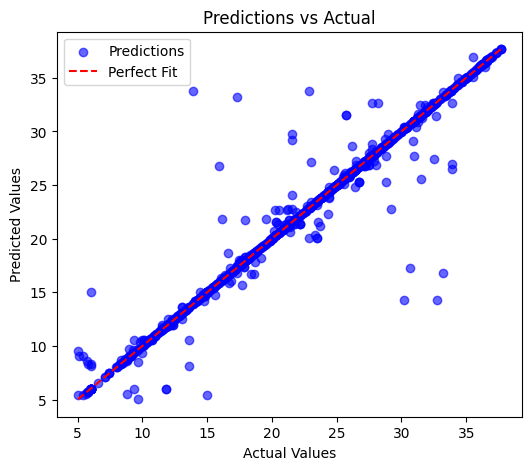

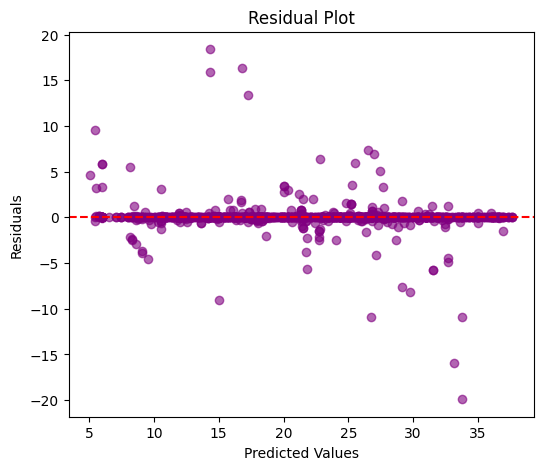

In [53]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual')
plt.legend()
plt.show()

residuals = y_test - y_test_pred

plt.figure(figsize=(6, 5))
plt.scatter(y_test_pred, residuals, color='purple', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


In [54]:
# Cross Validatino
from sklearn.model_selection import cross_val_score

regressor_custom_validation= DecisionTreeRegressorCustom(min_samples_split=2, max_depth=100, min_samples_leaf=4)
# Perform 5-fold cross-validation using R² as the scoring metric
cv_scores = cross_val_score(regressor_custom, X_train, y_train, cv=15, scoring='r2')

# Print results
print("Cross-validation R2 scores:", cv_scores)
print("Mean R2:", np.mean(cv_scores))
print("Standard Deviation:", np.std(cv_scores))


Cross-validation R2 scores: [0.94716651 0.95188915 0.97133902 0.97526919 0.98244894 0.98944344
 0.95866792 0.90725698 0.95662681 0.89626591 0.9454135  0.97085451
 0.98191714 0.97245818 0.97529908]
Mean R2: 0.9588210860997705
Standard Deviation: 0.025819189331166104


In [55]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# ---------- 1. Without Hyperparameter Optimization ----------
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Ridge Regression
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Lasso Regression
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Decision Tree Regressor
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_test, y_pred_dt)

# K-Nearest Neighbors Regressor
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
r2_knn = r2_score(y_test, y_pred_knn)

# Print results without hyperparameter optimization
print("Without Hyperparameter Optimization:")
print(f"Linear Regression - RMSE: {rmse_lr}, R-squared: {r2_lr}")
print(f"Ridge Regression - RMSE: {rmse_ridge}, R-squared: {r2_ridge}")
print(f"Lasso Regression - RMSE: {rmse_lasso}, R-squared: {r2_lasso}")
print(f"Decision Tree - RMSE: {rmse_dt}, R-squared: {r2_dt}")
print(f"KNN Regressor - RMSE: {rmse_knn}, R-squared: {r2_knn}")

# ---------- 2. With Hyperparameter Optimization ----------

# Decision Tree Regressor Hyperparameter Optimization
dt_param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt_grid_search = GridSearchCV(DecisionTreeRegressor(), dt_param_grid, cv=5, scoring='r2', n_jobs=-1)
dt_grid_search.fit(X_train, y_train)
dt_best = dt_grid_search.best_estimator_

# KNN Regressor Hyperparameter Optimization
knn_param_grid = {
    'n_neighbors': [3, 5, 10, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_grid_search = GridSearchCV(KNeighborsRegressor(), knn_param_grid, cv=5, scoring='r2', n_jobs=-1)
knn_grid_search.fit(X_train, y_train)
knn_best = knn_grid_search.best_estimator_

# Ridge Regression Hyperparameter Optimization
ridge_param_grid = {'alpha': [0.1, 1, 10, 100]}
ridge_grid_search = GridSearchCV(Ridge(), ridge_param_grid, cv=5, scoring='r2', n_jobs=-1)
ridge_grid_search.fit(X_train, y_train)
ridge_best = ridge_grid_search.best_estimator_

# Lasso Regression Hyperparameter Optimization
lasso_param_grid = {'alpha': [0.1, 1, 10, 100]}
lasso_grid_search = GridSearchCV(Lasso(), lasso_param_grid, cv=5, scoring='r2', n_jobs=-1)
lasso_grid_search.fit(X_train, y_train)
lasso_best = lasso_grid_search.best_estimator_

# Predictions using the best models
y_pred_dt_best = dt_best.predict(X_test)
y_pred_knn_best = knn_best.predict(X_test)
y_pred_ridge_best = ridge_best.predict(X_test)
y_pred_lasso_best = lasso_best.predict(X_test)

# Evaluate models after hyperparameter optimization
rmse_dt_best = np.sqrt(mean_squared_error(y_test, y_pred_dt_best))
r2_dt_best = r2_score(y_test, y_pred_dt_best)

rmse_knn_best = np.sqrt(mean_squared_error(y_test, y_pred_knn_best))
r2_knn_best = r2_score(y_test, y_pred_knn_best)

rmse_ridge_best = np.sqrt(mean_squared_error(y_test, y_pred_ridge_best))
r2_ridge_best = r2_score(y_test, y_pred_ridge_best)

rmse_lasso_best = np.sqrt(mean_squared_error(y_test, y_pred_lasso_best))
r2_lasso_best = r2_score(y_test, y_pred_lasso_best)

# Print results with hyperparameter optimization
print("\nWith Hyperparameter Optimization:")
print(f"Decision Tree - Best RMSE: {rmse_dt_best}, Best R-squared: {r2_dt_best}")
print(f"KNN Regressor - Best RMSE: {rmse_knn_best}, Best R-squared: {r2_knn_best}")
print(f"Ridge Regression - Best RMSE: {rmse_ridge_best}, Best R-squared: {r2_ridge_best}")
print(f"Lasso Regression - Best RMSE: {rmse_lasso_best}, Best R-squared: {r2_lasso_best}")

Without Hyperparameter Optimization:
Linear Regression - RMSE: 7.916042639931879, R-squared: 0.06409826364056115
Ridge Regression - RMSE: 7.9160281350303645, R-squared: 0.06410169342250982
Lasso Regression - RMSE: 8.040807425940931, R-squared: 0.034364273461730765
Decision Tree - RMSE: 1.5926165930703713, R-squared: 0.9621176880804446
KNN Regressor - RMSE: 5.020846244565821, R-squared: 0.6234975147623767

With Hyperparameter Optimization:
Decision Tree - Best RMSE: 1.441258374410207, Best R-squared: 0.9689760072100322
KNN Regressor - Best RMSE: 3.9314555661951816, Best R-squared: 0.7691548543286174
Ridge Regression - Best RMSE: 7.914860647904227, Best R-squared: 0.06437773303013938
Lasso Regression - Best RMSE: 7.914052140915509, Best R-squared: 0.06456887183574989
